In [17]:
import os
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import hashlib
import seaborn as sns
from Bio import SeqIO

In [18]:
def get_md5sum(x):
    return hashlib.md5(x.encode("utf-8")).hexdigest()[:10]

In [19]:
configs=['carpedeam2.configSafe', 'carpedeam2.configUnsafe', 'megahit.config0', 'penguin.config0', 'spades.config0'] 
main_df = big_df[big_df["assemblerconfig"].isin(main)]

In [20]:
datasets=["ancientCalc", "ancientGut", "ancientHorse"]

In [ ]:
labels = ["gut_sum_high_c3", "gut_sum_high_c5", "gut_sum_high_c10", \
 "calc_2095_high_c3", "calc_2095_high_c5", "calc_2095_high_c10", \
 "horse_sum_high_c3", "horse_sum_high_c5", "horse_sum_high_c10", ]

labels_clean = [
    "Gut:\nHigh Damage; Cov. 3X",
    "Gut:\nHigh Damage; Cov. 5X",
    "Gut:\nHigh Damage; Cov. 10X",
    "Calculus:\nHigh Damage; Cov. 3X",
    "Calculus:\nHigh Damage; Cov. 5X",
    "Calculus:\nHigh Damage; Cov. 10X",
    "Bone:\nHigh Damage; Cov. 3X",
    "Bone:\nHigh Damage; Cov. 5X",
    "Bone:\nHigh Damage; Cov. 10X",
]

labels_dict = {key: get_md5sum(key) for key in labels}
labels_dict_inv = {value: key for key, value in labels_dict.items()}
print(labels_dict_inv)

labels_dict_clean = {labels[i] : labels_clean[i] for i in range(len(labels))}

In [22]:
def map_assembler(cell):
    if "carpedeam" in cell:
        return "CarpeDeam"
    elif "penguin" in cell:
        return "PenguiN"
    elif "megahit" in cell:
        return "MEGAHIT"
    elif "spades" in cell:
        return "metaSPAdes"
    else:
        return cell  # Return the cell as is if none of the conditions are met

In [23]:
def adjust_assemblerconfig(row):
    if row["assembler_clean"] == "CarpeDeam":
        if "carpedeamSafe" in row["assemblerconfig"]:
            return "CarpeDeam\n(safe mode)"
        elif "carpedeamUnsafe" in row["assemblerconfig"]:
            return "CarpeDeam\n(unsafe mode)"
        else:
            return "CarpeDeam"
    else:
        return row["assembler_clean"]

In [24]:
def filter_contigs(directory, min_length, configs):
    # Find all FASTA files in the specified directory
    fasta_files = glob.glob(os.path.join(directory, "*_rep_seq.fasta"))
    
    # Dictionary to store the information
    contig_info = {}

    for file in fasta_files:

        if not any(config in file for config in configs):
            continue
        # print(file)
        # Count the number of contigs with length >= min_length
        
        count = sum(1 for record in SeqIO.parse(file, "fasta") if len(record.seq) >= min_length)

        name = os.path.basename(file)

        assembler = re.search(r'assm.([a-zA-Z0-9]+).config', name).group(1)
        label = re.match(r'([a-z0-9]+).raw', name).group(1)
        config = re.search(r'config(\d+)', name).group(1)
        
        contig_info[name] = [count, assembler, label, config]

    # Create a DataFrame from the dictionary
    df = pd.DataFrame.from_dict(contig_info, orient='index', columns=['Count', 'Assembler', 'Label', 'Config'])
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Filename'}, inplace=True)

    # Add additional columns
    df["assemblerconfig"] = df["Assembler"] + " " + df["Config"]
    df["assembler_clean"] = df["Assembler"].apply(map_assembler)
    df["assembler_final"] = df.apply(adjust_assemblerconfig, axis=1)
    df["label"] = df["Label"].astype(str)
    df["label_human"] = df["Label"].map(labels_dict_inv)
    df["label_clean"] = df["label_human"].replace(labels_dict_clean)
    df["dataset_clean"] = df["label_clean"].str.split(":").str[0]
    df["coverage"] = df["label_human"].str.split("_").str[3].str[1::]
    df["damage"] = df["label_human"].str.split("_").str[2]

    return df

In [25]:
def plot_contiglengths(df, min_length):
    # Convert the relevant columns to a DataFrame suitable for plotting
    plot_df = df[['label_clean', 'Count', 'assembler_clean']].sort_values(by='label_clean')
    
    # Define a custom palette for consistent color coding
    assembler_order = sorted(df["assembler_clean"].unique())

    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")

    # Create a grouped bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='label_clean', y='Count', hue='assembler_clean', data=plot_df, 
                hue_order=assembler_order)
    
    # Customize the plot with labels and title
    plt.xlabel('Label Clean')
    plt.ylabel(f'Number of Contigs (length >= {min_length} bp)')
    plt.title(f'Number of Contigs with Length >= {min_length} bp Grouped by Assembler')
    plt.xticks(rotation=90)
    plt.legend(title='Assembler')
    plt.tight_layout()
    plt.show()

In [26]:
def curate_df(datasets, min_length):

    dfs = []
    for data in datasets:
        directory = f"/data/{data}/results/assembly_clean/clusteredResults"
        df = filter_contigs(directory, min_length, configs)
        dfs.append(df)
        
    big_df = pd.concat(dfs, ignore_index=True)
    return big_df

# Plot number of correct sequences

In [27]:
def plot_num_correct(df_orig, damage, minLen, bar_width=0.6):
    # Filter dataframe based on damage
    df = df_orig[df_orig["damage"] == damage]
    
    # Define a custom palette for consistent color coding
    custom_palette = ['#a1c9f4', '#b9f2f0', '#8de5a1', '#ffb482', '#fab0e4']
    
    # Set custom order for assemblers
    custom_order = [
        'CarpeDeam\n(safe mode)',
        'CarpeDeam\n(unsafe mode)',
        'PenguiN',
        'MEGAHIT',
        'metaSPAdes'
    ]
    
    assembler_order = sorted(df["assembler_final"].unique(), key=lambda x: custom_order.index(x))
    
    # Convert 'assembler_final' to categorical type with custom order
    df['assembler_final'] = pd.Categorical(df['assembler_final'], categories=assembler_order, ordered=True)
    
    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")
    
    # Set custom order for coverages
    coverage_order = ["3", "5", "10"]
    df['coverage'] = pd.Categorical(df['coverage'], categories=coverage_order, ordered=True)
    
    # Determine the number of unique values for dataset_clean
    datasets = sorted(df['dataset_clean'].unique())
    
    # Set up the subplots grid with appropriate size
    fig_width = 12
    fig_height = 12
    fig, axs = plt.subplots(3, 3, figsize=(fig_width, fig_height), sharey=False)
    
    # Plot each subplot
    plot_idx = 0
    for dataset in datasets:
        for coverage in coverage_order:
            i, j = divmod(plot_idx, 3)  # Determine subplot position
            if i < 3 and j < 3:
                ax = axs[i, j]
                subset = df[(df['dataset_clean'] == dataset) & (df['coverage'] == coverage)]
                
                if not subset.empty:
                    sns.barplot(
                        x='assembler_final', 
                        y='Count', 
                        hue='assembler_final', 
                        data=subset, 
                        ax=ax, 
                        palette=custom_palette, 
                        hue_order=assembler_order,
                        errorbar=None,
                        dodge=False,
                        width=bar_width
                    )
                    ax.set_title(f'Dataset: {dataset}, Coverage: {coverage}X')
                    ax.set_xlabel('Assembler')
                    if j == 0:
                        ax.set_ylabel('# correct sequences > 2000bp')
                    else:
                        ax.set_ylabel('')
                    ax.tick_params(axis='x', rotation=90, labelsize=10)
                    #ax.legend().set_visible(False)
                plot_idx += 1
    
    # Remove empty subplots
    for i in range(3):
        for j in range(3):
            if i * 3 + j >= plot_idx:
                fig.delaxes(axs[i][j])
    
    # Add a single legend below the plot if there are handles
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, title='Assembler', bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=len(labels))
    
    plt.tight_layout()
    plt.savefig(f'plots/figure4/correct_contigs.svg', format="svg", bbox_inches="tight")
    plt.show()

In [28]:
df = curate_df(datasets, 2000)

/tmp/ipykernel_1758692/349718630.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['assembler_final'] = pd.Categorical(df['assembler_final'], categories=assembler_order, ordered=True)
/tmp/ipykernel_1758692/349718630.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['coverage'] = pd.Categorical(df['coverage'], categories=coverage_order, ordered=True)


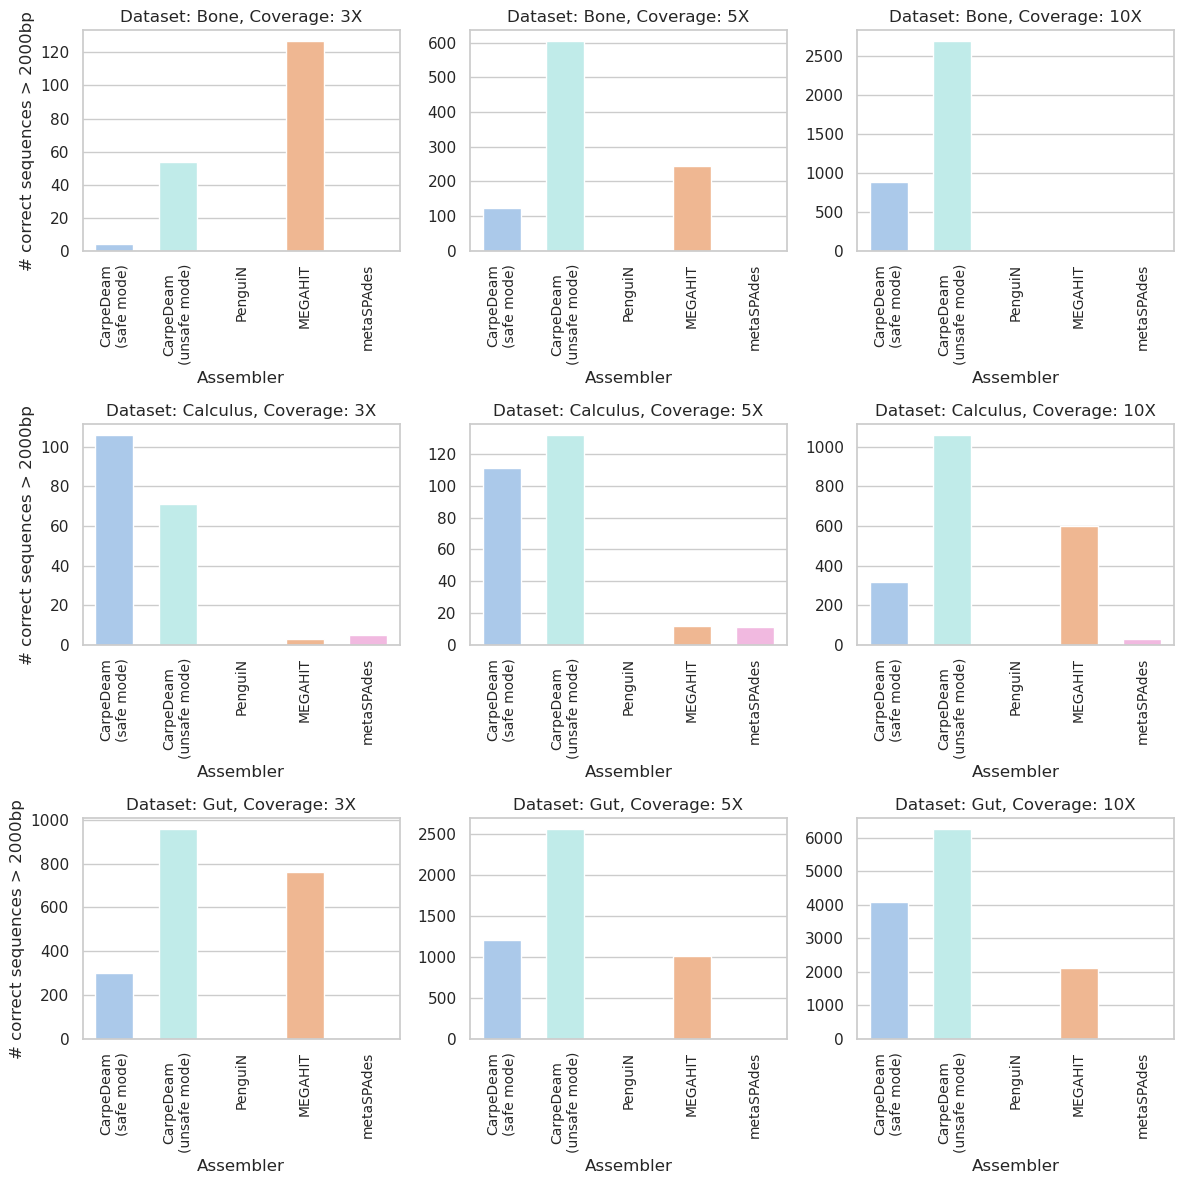

In [25]:
plot_num_correct(df, "high", 2000)